In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite
from typing import Union
from scipy.signal import correlate

In [116]:
# Параметры задания
P = 8
INITIAL_SIGMA = 0.5
N = 256  # Количество точек для БПФ
M = 1024  # Количество точек для метода прямоугольников
A = 5  # Границы диапазона
hx = (2 * A) / N  # Шаг по x
x = np.linspace(-A, A - hx, N)  # Массив значений x

# Область частот для БПФ
du = 1 / (N * hx)
u = np.linspace(-N / 2 * du, (N / 2 - 1) * du, N)

In [117]:
def hermite_gaussian_mode(p: int, x: np.ndarray, sigma: Union[float, int]) -> np.ndarray:
    """
    Вычисляет моду Гаусса-Эрмита порядка p.

    :param p: порядок полинома Эрмита
    :param x: массив значений x
    :param sigma: параметр сигма
    :return: значения моды Гаусса-Эрмита
    """
    H_p = hermite(p)(x / sigma)
    return H_p * np.exp(-(x / sigma) ** 2 / 2)


def rectangular_method(f: np.ndarray, x: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Вычисляет преобразование Фурье методом прямоугольников.

    :param f: функция, для которой выполняется преобразование Фурье
    :param x: массив значений x
    :param u: массив частот u
    :return: преобразование Фурье методом прямоугольников
    """
    hx = x[1] - x[0]  # Шаг по x
    F_u = np.zeros_like(u, dtype=complex)
    for i in range(len(u)):
        F_u[i] = np.sum(f * np.exp(-2j * np.pi * u[i] * x)) * hx
    return F_u


def plot_signal_amplitude_and_phase(x: np.ndarray, f_x: np.ndarray, title_prefix: str = "") -> None:
    """
    Построение графиков амплитуды и фазы входного сигнала.

    :param x: массив значений x
    :param f_x: входной сигнал
    :param title_prefix: префикс для заголовка графика
    """
    plt.figure()
    plt.plot(x, np.abs(f_x), label="Амплитуда")
    plt.title(f"{title_prefix}Амплитуда входного сигнала")
    plt.xlabel("x")
    plt.ylabel("Амплитуда")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(x, np.angle(f_x), label="Фаза")
    plt.title(f"{title_prefix}Фаза входного сигнала")
    plt.xlabel("x")
    plt.ylabel("Фаза")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_fourier_amplitude_and_phase(u: np.ndarray, fft_f: np.ndarray, f_u_rect: np.ndarray, title_prefix: str = "") -> None:
    """
    Построение графиков амплитуды и фазы для БПФ и метода прямоугольников.

    :param u: массив частот u
    :param fft_f: преобразование Фурье, полученное через БПФ
    :param f_u_rect: преобразование Фурье, полученное методом прямоугольников
    :param title_prefix: префикс для заголовка графика
    """
    plt.figure()
    plt.plot(u, np.abs(fft_f), label="Амплитуда БПФ")
    plt.plot(u, np.abs(f_u_rect), '--', label="Амплитуда метода прямоугольников")
    plt.title(f"{title_prefix}Амплитуда: БПФ и метод прямоугольников")
    plt.xlabel("u")
    plt.ylabel("Амплитуда")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(u, np.angle(fft_f), label="Фаза БПФ")
    plt.plot(u, np.angle(f_u_rect), '--', label="Фаза метода прямоугольников")
    plt.title(f"{title_prefix}Фаза: БПФ и метод прямоугольников")
    plt.xlabel("u")
    plt.ylabel("Фаза")
    plt.legend()
    plt.grid(True)
    plt.show()

In [131]:
# Грубый поиск оптимального sigma
sigma_values = np.linspace(0.4, 0.75, 10)  # Грубый диапазон значений sigma
max_corr = -float('inf')
optimal_sigma = 0.707
for sigma in sigma_values:
    f_x = hermite_gaussian_mode(P, x, sigma)
    FFT_f = np.fft.fftshift(np.fft.fft(np.fft.fftshift(f_x))) * hx
    F_u_rect = rectangular_method(f_x, x, u)
    
    # Нормализация амплитуд
    FFT_f_normalized = np.abs(FFT_f) / np.max(np.abs(FFT_f))
    F_u_rect_normalized = np.abs(F_u_rect) / np.max(np.abs(F_u_rect))
    
    # Перекрестная корреляция
    correlation = np.max(correlate(FFT_f_normalized, F_u_rect_normalized))
    
    if correlation > max_corr:
        max_corr = correlation
        optimal_sigma = sigma

# Точный поиск вокруг грубо найденного значения
fine_sigma_values = np.linspace(optimal_sigma - 0.005, optimal_sigma + 0.005, 100)
for sigma in fine_sigma_values:
    f_x = hermite_gaussian_mode(P, x, sigma)
    FFT_f = np.fft.fftshift(np.fft.fft(np.fft.fftshift(f_x))) * hx
    F_u_rect = rectangular_method(f_x, x, u)
    
    # Нормализация амплитуд
    FFT_f_normalized = np.abs(FFT_f) / np.max(np.abs(FFT_f))
    F_u_rect_normalized = np.abs(F_u_rect) / np.max(np.abs(F_u_rect))
    
    # Перекрестная корреляция
    correlation = np.max(correlate(FFT_f_normalized, F_u_rect_normalized))
    
    if correlation > max_corr:
        max_corr = correlation
        optimal_sigma = sigma

In [132]:
optimal_sigma

0.39631313131313134

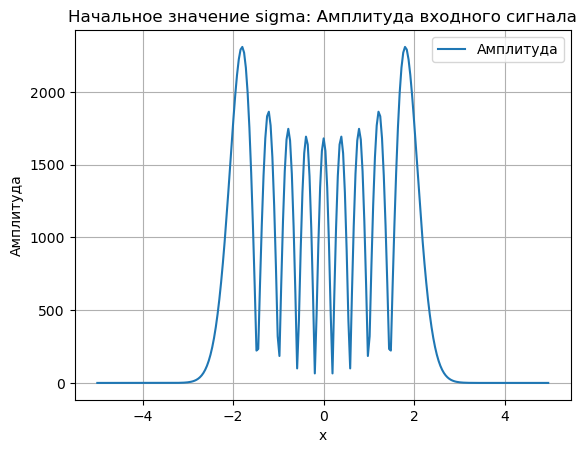

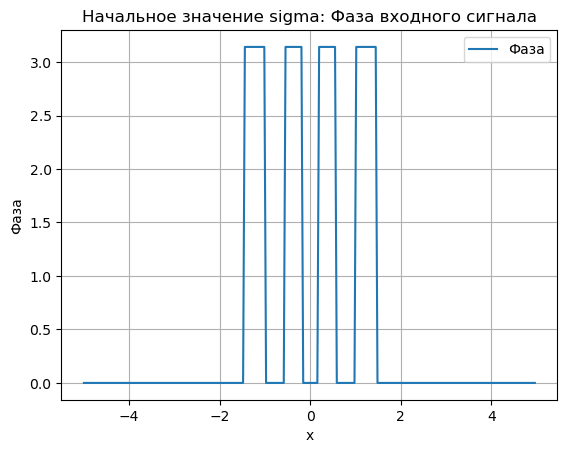

In [133]:
# Входной сигнал с начальным значением sigma
f_x_initial = hermite_gaussian_mode(P, x, INITIAL_SIGMA)
plot_signal_amplitude_and_phase(x, f_x_initial, "Начальное значение sigma: ")

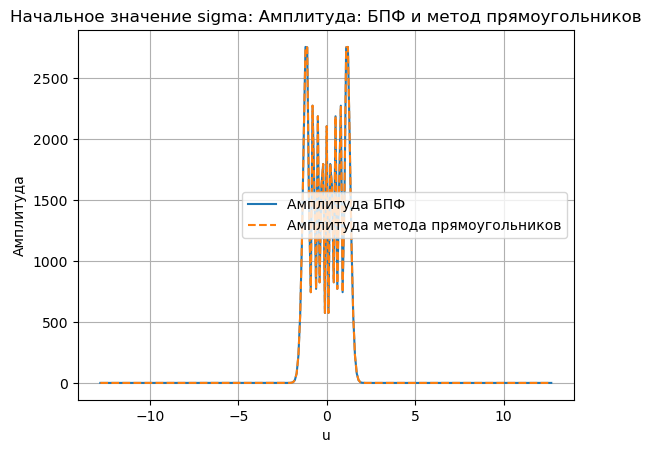

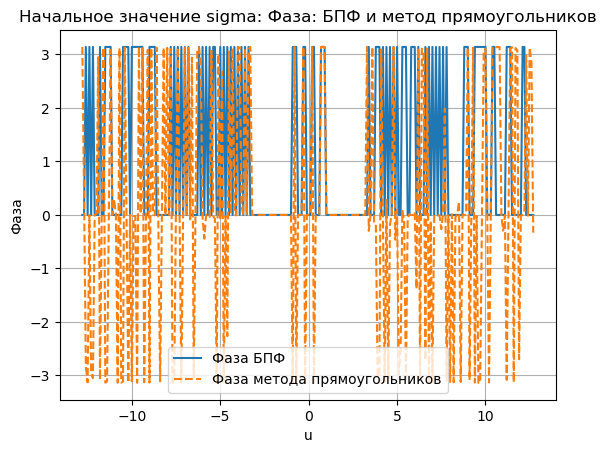

In [134]:
# БПФ и метод прямоугольников для начального sigma
FFT_f_initial = np.fft.fftshift(np.fft.fft(np.fft.fftshift(f_x_initial))) * hx
F_u_rect_initial = rectangular_method(f_x_initial, x, u)
plot_fourier_amplitude_and_phase(u, FFT_f_initial, F_u_rect_initial, "Начальное значение sigma: ")

In [135]:
# Входной сигнал с оптимальным значением sigma
f_x_optimal = hermite_gaussian_mode(P, x, optimal_sigma)
FFT_f_optimal = np.fft.fftshift(np.fft.fft(np.fft.fftshift(f_x_optimal))) * hx
F_u_rect_optimal = rectangular_method(f_x_optimal, x, u)

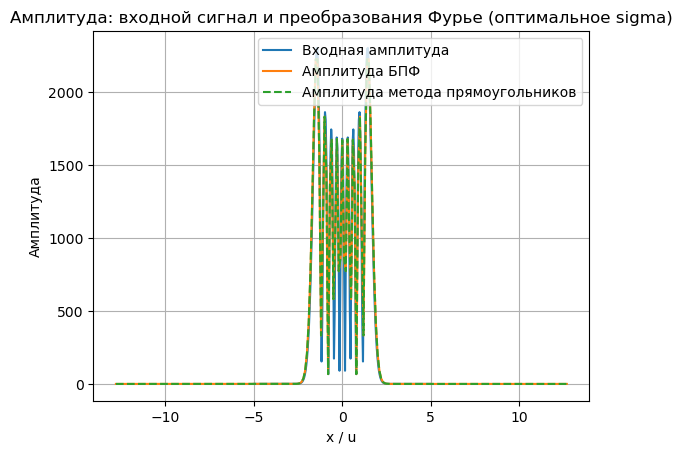

In [136]:
# Построение графиков с оптимальным sigma
plt.figure()
plt.plot(x, np.abs(f_x_optimal), label="Входная амплитуда")
plt.plot(u, np.abs(FFT_f_optimal), label="Амплитуда БПФ")
plt.plot(u, np.abs(F_u_rect_optimal), '--', label="Амплитуда метода прямоугольников")
plt.title("Амплитуда: входной сигнал и преобразования Фурье (оптимальное sigma)")
plt.xlabel("x / u")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True)
plt.show()

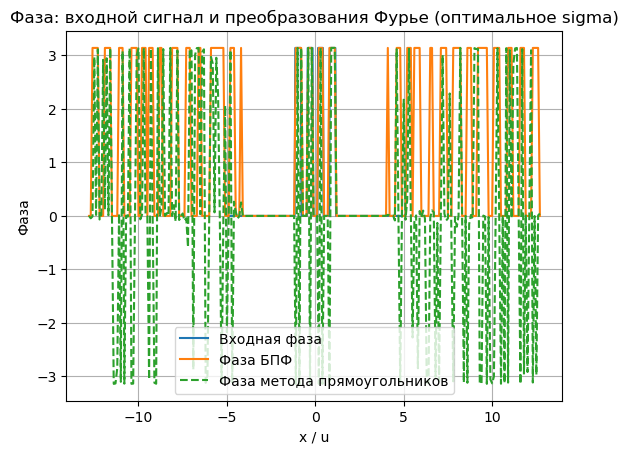

In [137]:
plt.figure()
plt.plot(x, np.angle(f_x_optimal), label="Входная фаза")
plt.plot(u, np.angle(FFT_f_optimal), label="Фаза БПФ")
plt.plot(u, np.angle(F_u_rect_optimal), '--', label="Фаза метода прямоугольников")
plt.title("Фаза: входной сигнал и преобразования Фурье (оптимальное sigma)")
plt.xlabel("x / u")
plt.ylabel("Фаза")
plt.legend()
plt.grid(True)
plt.show()